# **Knowledge Representation in RAG methods**

Contributors:
* Szymon Pająk
* Tomasz Ogiołda

---

## **Introduction**

### **Hook**
- *"Imagine asking an AI: 'Find me a cheerful song from the 90s by an artist like Queen, but not actually Queen, and something I haven't heard a million times.' How can we build AI that *truly* understands and navigates complex requests over *your* specific data?"*

- *"Large Language Models (LLMs) are powerful, but they don't know everything, especially about recent events or your private information. How can we bridge this gap without constant, costly retraining?"*

---

### **Agenda Overview**

1. **What is RAG & Why Knowledge Representation Matters**

2. **Common Knowledge Representation Options for RAG:**

   - Vector Embeddings  

   - Knowledge Graphs  

   - The Hybrid: GraphRAG  

3. **Demo:** Building a Knowledge Graph from Spotify Data (using our notebook!)  

4. **The GraphRAG Ecosystem & Future**  
5. **Conclusion & Q&A**  

---

### **What is RAG?**

- **RAG = Retrieval Augmented Generation**  

- It's a technique to enhance LLM responses by first retrieving relevant information from an external knowledge base and providing it to the LLM as context.  

![image.png](https://github.com/szpajak/PresentationKR/blob/main/images/what_is_rag.png?raw=1)

#### **Why RAG?**

- **Reduces Hallucinations:** LLMs are less likely to make things up if they have relevant facts.  

- **Access to Current Data:** Overcomes knowledge cut-offs.  
- **Domain-Specific Knowledge:** Allows LLMs to answer questions about private or specialized data.  
- **Cost-Effective:** Cheaper than fine-tuning an LLM for every new piece of information.  
- **Verifiability:** Users can often see the source of the information.  

---

### **The "Knowledge" in RAG**

- The effectiveness of RAG heavily depends on **how we store, organize, and retrieve this external knowledge.**  

- This is where **Knowledge Representation** comes in. It's about choosing the right structure for your data so the "Retrieval" part of RAG is smart and efficient.


## **Knowledge Representation Options in RAG**


![image.png](https://github.com/szpajak/PresentationKR/blob/main/images/apple-vector-knowledge-graph.png?raw=1)
---

### **Option 1: Vectorized Embeddings**

**Concept:**

- Text (documents, sentences, words) is converted into dense numerical vectors (embeddings).

- These vectors capture semantic meaning – similar concepts have vectors that are close together in "vector space."

**How it works in RAG:**

1. Your documents are chunked and each chunk is embedded. These embeddings are stored in a Vector Database.

2. The user's query is also embedded.
3. A similarity search (e.g., cosine similarity) is performed to find the document chunks most similar to the query.
4. These chunks are passed to the LLM as context.

**Pros:**

- Excellent for semantic similarity searches ("find me documents about X").

- Relatively mature technology and many tools available.
- Can be straightforward to implement for basic RAG.

**Cons:**

- **"Bag of words" problem:** Can lose nuanced relationships and context between pieces of information.

- **Black Box:** Similarity scores don't always explain *why* something is relevant.
- Retrieves chunks, which might not be the most efficient or complete context.

---

### **Option 2: Knowledge Graphs (KGs)**


![image.png](https://github.com/szpajak/PresentationKR/blob/main/images/knowledge_graph.png?raw=1)

**Concept:**

- Information is represented as a network of:

  - **Nodes (Entities):** Things, concepts, people (e.g., "Song," "Artist," "Genre").

  - **Edges (Relationships):** How entities are connected (e.g., an `Artist` node `PERFORMED` a `Song` node).
  - **Properties:** Attributes of nodes and relationships (e.g., a `Song` node has a `title` property).



**How it works in RAG:**

1. Your data is modeled and ingested into a Graph Database (like Neo4j).

2. The user's query can be parsed to identify entities and relationships.
3. The system can traverse the graph, following relationships to find highly relevant and contextual subgraphs.
4. This rich, structured context is passed to the LLM.

**Pros:**

- **Explicit Relationships:** Captures how information is interconnected, leading to more precise retrieval.

- **Context-Rich:** Retrieves subgraphs that provide a fuller picture, not just isolated chunks.
- **Explainable:** The path through the graph can explain *why* information is relevant.
- **Powerful for Complex Queries:** Can answer questions that require hopping across multiple entities and relationships.

**Cons:**

- Can be more complex to design and build the initial graph schema.
- Requires a different way of thinking about data (connections first).

---

### **Option 3: The Hybrid Approach – GraphRAG**

**Concept: Combining the strengths of KGs and Vector Embeddings.**


**How it can work:**

- Store rich, structured data in a Knowledge Graph.

- Generate vector embeddings for text properties within the graph (e.g., song lyrics, album descriptions) or even for nodes/subgraphs.

**Use Cases:**

1. Use KG traversal for structured queries and then vector search *within* the retrieved nodes for semantic details.

2. Use vector search to find initial entry points into the graph, then expand with graph traversal to get more context.
3. Embed and search for graph patterns or subgraphs.

**Benefits:**

- **Best of Both Worlds:** Precise, contextual retrieval from KGs + powerful semantic search from vectors.

- Handles a wider variety of queries.
- Leads to more nuanced and accurate information retrieval for the LLM.

---

### **Comparison Table**

![image.png](https://github.com/szpajak/PresentationKR/blob/main/images/comparison_table.png?raw=1)

---



## **Demo: Building a Knowledge Graph for Music Recommendation RAG**

#### **Goal**
*   To demonstrate how we can take tabular data (like our Spotify dataset) and transform it into a connected Knowledge Graph in Neo4j.

*   This graph will then serve as the "Knowledge Base" that a RAG system could use to answer music-related queries.

#### **1. Setup & Initialization**
*   Importing necessary libraries (Neo4j, Google Generative AI, Pandas).

*   Configuring API keys and Neo4j connection details.
*   Initializing the embedding model (`text-embedding-004`) and the generative LLM (`gemini-1.5-flash-latest`).

    *   *Embedding Model:* Will be used (conceptually in a full RAG) to turn text like lyrics or queries into vectors.

    *   *Generative LLM:* Will be used (conceptually) to generate the final natural language response based on retrieved context.

##### Code

In [ ]:
!pip install neo4j neo4j_graphrag sentence_transformers google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.4/180.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.4/303.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import userdata

NEO4J_URI = userdata.get('NEO4J_URI')
NEO4J_PASS = userdata.get('NEO4J_PASS')
NEO4J_DB_USER = userdata.get('NEO4J_DB_USER')
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [ ]:
from neo4j import GraphDatabase

URI = "neo4j+s://3a2f9088.databases.neo4j.io"

def get_db():
  with GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_DB_USER, NEO4J_PASS)) as driver:
      driver.verify_connectivity()
      return driver

In [ ]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("devdope/900k-spotify")
songs_csv_path = path + '/spotify_dataset.csv'
full_df = pd.read_csv(songs_csv_path)

In [ ]:
import numpy as np

np.random.seed(9)

df = full_df.sample(20000)
df = df[['Artist(s)','song', 'text', 'emotion', 'Length', 'Album', 'Genre', 'Energy', 'Popularity', 'Danceability', 'Positiveness']]
df[['Energy', 'Popularity', 'Danceability', 'Positiveness']] = df[['Energy', 'Popularity', 'Danceability', 'Positiveness']].astype(int)/100

#### **2. Data Loading & Preparation**

*   We're using a Spotify dataset with ~900k songs (we'll sample 20k for the demo).

*   Loading into a Pandas DataFrame.
*   It includes information like:

    *   `Artist(s)`, `song` title, `text` (lyrics), `emotion`, `Length`, `Album`, `Genre`, `Energy`, `Popularity`, `Danceability`, `Positiveness`.

In [ ]:
df.head(3)

,Artist(s),song,text,emotion,Length,Album,Genre,Energy,Popularity,Danceability,Positiveness
465551,The Cast of Mary Poppins,Mary Poppins,"[Verse 1] Rose gold, rose quartz Stone cold, w...",anger,02:02,Mary Poppins Original Soundtrack,hip hop,0.61,0.35,0.53,0.92
5902,98º,If Only She Knew,"If only she knew What was going right, I...",joy,04:27,98 Degrees And Rising,hip hop,0.46,0.29,0.76,0.59
84105,CHASETHEMONEY,Been Dat,[Intro: Lil Yachty] Chase the money 'til a nig...,joy,01:42,Slim.E and Friends,hip hop,0.42,0.22,0.86,0.51


#### **3. Neo4j Ingestion: Building the Knowledge Graph!**

*   Music is inherently connected! Here are the relationships:
    
    *   Artists **PERFORM** Songs.
    
    *   Songs **APPEAR_ON** Albums.
    *   Songs **HAVE_GENRE** Genre.
    *   Songs can **EVOKE** Emotions.
    *   Artists can **COLLABORATE_WITH** other Artists (implicitly through songs).

*   These relationships explicitly, enabling powerful contextual queries that are hard with just tables or vectors alone.
    
    *   "Find rock songs by artists who also play blues and have collaborated with..."
    *   "Show me upbeat songs from albums that were popular in a specific year."


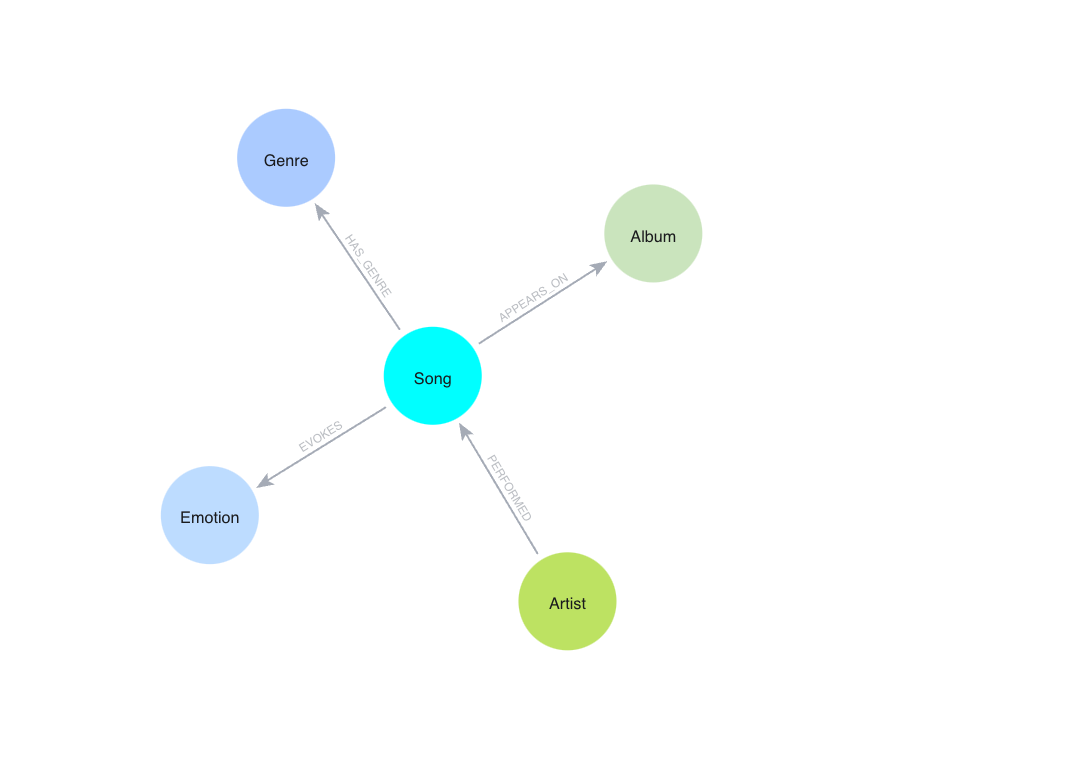

#### **Creating vector index**

Song nodes store vector embedding of the full song record.

```py
EMBEDDING_DIMENSION = 384 # SentenceTransformer embedder default embedding size
VECTOR_INDEX_NAME = "songIndex"
PROPERTY_FOR_VECTOR = "embedding" # We packed all song information and vectorized it under `embedding` field

CALL db.index.vector.createNodeIndex(
            '{VECTOR_INDEX_NAME}',
            'Song',
            '{PROPERTY_FOR_VECTOR}',
            {EMBEDDING_DIMENSION},
            'cosine'
        )
```

##### **Data ingestion code**

In [ ]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import neo4j
from time import perf_counter

def process_song_row(row_data, song_id, db_uri, db_user, db_password):
    try:
        driver = neo4j.GraphDatabase.driver(db_uri, auth=(db_user, db_password))
        start = perf_counter()

        with driver.session() as session:
            song_title = row_data['song']
            lyrics = str(row_data['text'])
            emotion = row_data['emotion']
            time_length = row_data['Length']
            album_name = row_data['Album']
            energy = row_data['Energy']
            popularity = row_data['Popularity']
            danceability = row_data['Danceability']
            positiveness = row_data['Positiveness']

            combined_text = (
                f"Song Title: {song_title}. "
                f"Artist(s): {row_data['Artist(s)']}. " # Directly use row_data for artist, album, genre for conciseness
                f"Album: {album_name}. "
                f"Genre: {row_data['Genre']}. "
                f"Emotion: {emotion}. "
                f"Length: {time_length} seconds. " # Include numerical info as text for embedder context
                f"Energy: {energy}. "
                f"Popularity: {popularity}. "
                f"Danceability: {danceability}. "
                f"Positiveness: {positiveness}. "
                f"Lyrics: {lyrics}"
            )

            # print(perf_counter()-start)

            embedding = embedder.embed_query(combined_text)

            session.run("""
                MERGE (s:Song {id: $song_id})
                ON CREATE SET
                    s.title = $song_title,
                    s.lyrics = $lyrics,
                    s.time_length = $time_length,
                    s.energy = $energy,
                    s.popularity = $popularity,
                    s.danceability = $danceability,
                    s.positiveness = $positiveness,
                    s.embedding = $embedding
                ON MATCH SET
                    s.title = $song_title,
                    s.lyrics = $lyrics,
                    s.time_length = $time_length,
                    s.energy = $energy,
                    s.popularity = $popularity,
                    s.danceability = $danceability,
                    s.positiveness = $positiveness,
                    s.embedding = $embedding
            """, song_id=song_id, song_title=song_title, lyrics=lyrics,
               time_length=time_length, energy=float(energy) if pd.notna(energy) else None,
               popularity=float(popularity) if pd.notna(popularity) else None,
               danceability=float(danceability) if pd.notna(danceability) else None,
               positiveness=float(positiveness) if pd.notna(positiveness) else None,
               embedding=embedding
                        )

            # print(perf_counter()-start)

            # Artists
            artist_names = []
            if pd.notna(row_data['Artist(s)']):
                artist_names = [name.strip() for name in str(row_data['Artist(s)']).split(',')]
            for artist_name in artist_names:
                if artist_name:
                    session.run("""
                        MERGE (ar:Artist {name: $artist_name})
                        WITH ar
                        MATCH (s:Song {id: $song_id})
                        MERGE (ar)-[:PERFORMED]->(s)
                    """, artist_name=artist_name, song_id=song_id)
            # print(perf_counter()-start)
            # Album
            if pd.notna(album_name) and album_name.strip():
                session.run("""
                    MERGE (al:Album {name: $album_name})
                    WITH al
                    MATCH (s:Song {id: $song_id})
                    MERGE (s)-[:APPEARS_ON]->(al)
                """, album_name=album_name.strip(), song_id=song_id)

            # print(perf_counter()-start)
            # Genre
            genre_names = []
            if pd.notna(row_data['Genre']):
                genre_names = [name.strip() for name in str(row_data['Genre']).split(',')]
            for genre_name in genre_names:
                if genre_name:
                    session.run("""
                        MERGE (g:Genre {name: $genre_name})
                        WITH g
                        MATCH (s:Song {id: $song_id})
                        MERGE (s)-[:HAS_GENRE]->(g)
                    """, genre_name=genre_name, song_id=song_id)


            # print(perf_counter()-start)
            # Emotion
            if pd.notna(emotion) and emotion.strip():
                session.run("""
                    MERGE (e:Emotion {name: $emotion})
                    WITH e
                    MATCH (s:Song {id: $song_id})
                    MERGE (s)-[:EVOKES]->(e)
                """, emotion=emotion.strip(), song_id=song_id)
        driver.close() # Close driver for this task
        return f"Successfully processed song ID: {song_id}"
    except Exception as e:
        return f"Error processing song ID {song_id}: {e}"

def ingest_music_data_multithreaded(df, db_uri, db_user, db_password, max_workers=8):
    print(f"Starting multithreaded data ingestion for {len(df)} songs with {max_workers} workers...")

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for idx, row in df.iterrows():
            song_id = str(idx) # Ensure ID is a string for consistency
            futures.append(executor.submit(process_song_row, row, song_id, db_uri, db_user, db_password))

        processed_count = 0
        for future in as_completed(futures):
            result = future.result()
            processed_count += 1
            if "Error" in result:
                print(f"Error: {result}")
            # else:
            #     print(result) # Uncomment if you want to see success messages

            if processed_count % 100 == 0:
                print(f"Processed {processed_count}/{len(df)} songs.")

    print(f"Finished multithreaded data ingestion. Total processed: {processed_count}/{len(df)} songs.")

def create_constraints(db):
  with db.session() as session:
      session.run("CREATE CONSTRAINT IF NOT EXISTS FOR (s:Song) REQUIRE s.id IS UNIQUE")
      session.run("CREATE CONSTRAINT IF NOT EXISTS FOR (ar:Artist) REQUIRE ar.name IS UNIQUE")
      session.run("CREATE CONSTRAINT IF NOT EXISTS FOR (al:Album) REQUIRE al.name IS UNIQUE") # Album names might not be unique across artists
      session.run("CREATE CONSTRAINT IF NOT EXISTS FOR (g:Genre) REQUIRE g.name IS UNIQUE")
      session.run("CREATE CONSTRAINT IF NOT EXISTS FOR (e:Emotion) REQUIRE e.name IS UNIQUE")

      session.run("CREATE INDEX IF NOT EXISTS FOR (s:Song) ON (s.title)")
      session.run("CREATE INDEX IF NOT EXISTS FOR (al:Album) ON (al.name)") # If querying albums by name

      print("Neo4j constraints and basic indexes for music graph ensured.")

EMBEDDING_DIMENSION = 384
VECTOR_INDEX_NAME = "songIndex"
PROPERTY_FOR_VECTOR = "embedding"

def create_vector_index(db):
  create_index_query = f"""
        CALL db.index.vector.createNodeIndex(
            '{VECTOR_INDEX_NAME}',
            'Song',
            '{PROPERTY_FOR_VECTOR}',
            {EMBEDDING_DIMENSION},
            'cosine'
        )
    """
  with db.session() as session:
    session.run(create_index_query)

  print("Vector index for songs created.")

db = get_db()
# create_constraints(db)
# create_vector_index(db)
# ingest_music_data_multithreaded(df.iloc[5100:], NEO4J_URI, NEO4J_DB_USER, NEO4J_PASS, max_workers=4)

#### **Checking sample data**

Let's pick sample node and all of it's connections to verify the data is correct.

In [ ]:
import pprint

db = get_db()

res = db.execute_query("""
  MATCH (s:Song)-[r]->(n)
  WHERE s.title="Wheres the Revolution"
  RETURN s.title, r, n
""")

pprint.pprint(res.records)

<ipython-input-12-40d3a058bbe9>:5: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  res = db.execute_query("""


[<Record s.title='Wheres the Revolution' r=<Relationship element_id='5:984d301b-ddd6-42f3-9ea6-6495e0c2601c:1152922604118492833' nodes=(<Node element_id='4:984d301b-ddd6-42f3-9ea6-6495e0c2601c:18081' labels=frozenset() properties={}>, <Node element_id='4:984d301b-ddd6-42f3-9ea6-6495e0c2601c:13559' labels=frozenset({'Album'}) properties={'name': 'Spirit (Deluxe)'}>) type='APPEARS_ON' properties={}> n=<Node element_id='4:984d301b-ddd6-42f3-9ea6-6495e0c2601c:13559' labels=frozenset({'Album'}) properties={'name': 'Spirit (Deluxe)'}>>,
 <Record s.title='Wheres the Revolution' r=<Relationship element_id='5:984d301b-ddd6-42f3-9ea6-6495e0c2601c:1157427303257491105' nodes=(<Node element_id='4:984d301b-ddd6-42f3-9ea6-6495e0c2601c:18081' labels=frozenset() properties={}>, <Node element_id='4:984d301b-ddd6-42f3-9ea6-6495e0c2601c:62' labels=frozenset({'Genre'}) properties={'name': 'alternative rock'}>) type='HAS_GENRE' properties={}> n=<Node element_id='4:984d301b-ddd6-42f3-9ea6-6495e0c2601c:62' la

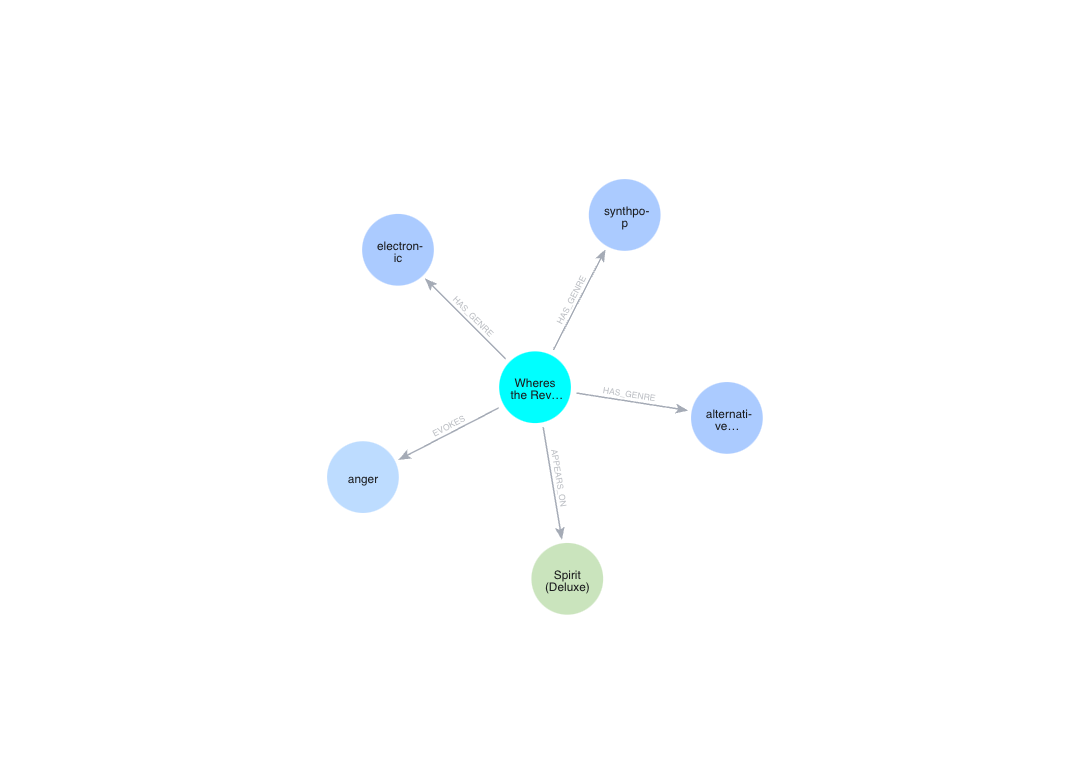

### **LLM & embedder of choice**

We used Gemini as LLM and HuggingFace's SentenceTransformer from generating embeddings.

In [ ]:
from neo4j_graphrag.retrievers import VectorRetriever, Text2CypherRetriever
from neo4j_graphrag.llm import LLMInterface, LLMResponse
from neo4j_graphrag.generation import GraphRAG
from neo4j_graphrag.embeddings import SentenceTransformerEmbeddings
import google.generativeai as genai

embedder = SentenceTransformerEmbeddings(model="all-MiniLM-L6-v2")

class GeminiLLM(LLMInterface):
    def __init__(self, model_name: str):
        genai.configure(api_key=GOOGLE_API_KEY)

        self.model = genai.GenerativeModel(model_name=model_name)

    def invoke(self, input: str, message_history=None, system_instruction=None) -> str:
        response = self.model.generate_content(input)

        return LLMResponse(content=response.text)

    def ainvoke(self, input: str, system_instruction=None) -> str:
        response = self.model.generate_content(input)
        return LLMResponse(content=response.text)


llm = GeminiLLM(model_name="gemini-1.5-flash-001")

### **Expected response template**

1. User asks the question about songs
2. It's vectorized using defined `embedder`
3. The `retriever` component gets the data from knowledge base, either:
   1. `EMBEDDING` -- The most relevant nodes based on embeddings (by the song vector index).
   2. `GRAPH` Full graph (user query -> Cypher query to neo4j -> graph), (rich information)
   3. `EMBEDDING + GRAPH` Utilizes both embeddings and rich contextual graph
4. The data retrieved from step 3 is inserted under `context` field for LLM.

In [ ]:
from neo4j_graphrag.generation import RagTemplate

prompt_template = RagTemplate(
    template="""
        You are a knowledgeable music expert. Your task is to provide accurate answers based solely on the provided song data.
        Explain the decision based on the data. Use thresholds very high > 0.9, high > 0.8, medium > 0.5, low < 0.5.

        Carefully consider the "Relevant Context" below.

        --- Relevant Context ---
        {context}
        --- End of Context ---

        Based on this context, answer the following "User Question".
        If you don't know the answer, just say that you don't know, don't try to make up an answer.
        Make sure the output is nicely formatted in markdown, use h3 headers. For multiple results use list.

        --- User Question ---
        {query_text}
        ---

        Music Expert's Answer:
      """,
    expected_inputs=["query_text", "context"]

)

### **1. Vectorized Embeddings RAG**

In this case, we treat Neo4j as it were just a regular vector database.

We perform cosine similarity queries on the song vector index -- the Song node's `embedding` field.

As we utilize just `VECTOR_INDEX_NAME` which is vector index on `Song` node, the retriever outputs only `Song` nodes, we can't access information such as `Album` or `Artists`.

<img src="https://github.com/szpajak/PresentationKR/blob/main/images/structure.png?raw=1"/>

In [ ]:
from IPython.display import display, Markdown
import logging

logging.getLogger("neo4j_graphrag").setLevel(logging.INFO)

driver = get_db()

vector_retriever = VectorRetriever(driver, VECTOR_INDEX_NAME, embedder)
vector_rag = GraphRAG(retriever=vector_retriever, llm=llm, prompt_template=prompt_template)

query_text = "Can you find me some energetic songs that will wake me up?"
response = vector_rag.search(
    query_text=query_text,
    retriever_config={"top_k": 3}
)

display(Markdown(response.answer))

### Music Expert's Answer:

Here are some energetic songs that will wake you up:

1. **'Wake Up' (id: 36341)**  has high energy (0.85) and high positivity (0.9). 
2. **'Wake Up Song' (id: 286742)** has high energy (0.84) and high danceability (0.94), making it a great choice to get you moving. 


### **2. Knowledge Graph RAG**

We supply our database schema, this lets the receiver to generate Neo4j DB query, we enrich the prompt with outputted graphs.

In this case, neo4j gives us all interconnected graph nodes for a `Song` node, this means we can access `Album` or `Artists`, HOWEVER the precision of results will be worse, since we don't perform any similarity search.

In [ ]:
neo4j_schema = """Node properties:
Artist {name: STRING}
Song {title: STRING, popularity: INT, lyrics: STRING, positiveness: INT, energy: INT, danceability: INT}
Album {name: STRING}
Genre {name: STRING}
Emotion {name: STRING}

Relationship properties:
PERFORMED {name: STRING}
APPEARS_ON {name: STRING}
HAS_GENRE {name: STRING}
EVOKES {name: STRING}

The relationships:
(:Artist)-[:PERFORMED]->(:Song)
(:Song)-[:APPEARS_ON]->(:Album)
(:Song)-[:HAS_GENRE]->(:Genre)
(:Song)-[:EVOKES]->(:Emotion)"""

logging.getLogger("neo4j_graphrag").setLevel(logging.INFO)

retriever = Text2CypherRetriever(
    driver=driver,
    llm=llm,
    neo4j_schema=neo4j_schema,
)
graph_rag = GraphRAG(retriever=retriever, llm=llm, prompt_template=prompt_template)

query_text = "What are the Depeche Mode albums?"
response = graph_rag.search(
    query_text=query_text,
)

display(Markdown(response.answer))

### Music Expert's Answer:

Based on the provided context, here are the Depeche Mode albums:

* **Sounds of the Universe (Deluxe)** - High confidence (appears twice)
* **Spirit (Deluxe)** - High confidence (appears twice)
* **Music for the Masses (Deluxe)** - High confidence (appears once)
* **Delta Machine** - High confidence (appears once)
* **Playing the Angel (Deluxe)** - High confidence (appears twice)
* **Exciter (Deluxe)** - High confidence (appears once) 


### **3. Hybrid approach**

It combines both of approaches:

1. Perform similarity search on vector embedded `Song` nodes.
2. Pick n best fitting nodes.
3. Enrich the embedded `Song` nodes with all relations it crates with other nodes, such as `Album` or `Artist`.

In [ ]:
from neo4j_graphrag.retrievers import VectorCypherRetriever

logging.getLogger("neo4j_graphrag").setLevel(logging.INFO)


retrieval_query = """
MATCH (node:Song)
OPTIONAL MATCH (node)<-[:PERFORMED]-(artist:Artist)
OPTIONAL MATCH (node)-[:APPEARS_ON]->(album:Album)
OPTIONAL MATCH (node)-[:HAS_GENRE]->(genre:Genre)
OPTIONAL MATCH (node)-[:EVOKES]->(emotion:Emotion)
WITH node, COLLECT(DISTINCT artist.name) AS artists,
            COLLECT(DISTINCT album.name) AS albums,
            COLLECT(DISTINCT genre.name) AS genres,
            COLLECT(DISTINCT emotion.name) AS emotions
RETURN {
    songId: node.id,
    songTitle: node.title,
    lyrics: node.lyrics,
    timeLength: node.time_length,
    energy: node.energy,
    popularity: node.popularity,
    danceability: node.danceability,
    positiveness: node.positiveness,
    artists: artists,
    album: albums,
    genres: genres,
    emotions: emotions
} as context
"""

retriever = VectorCypherRetriever(
    driver,
    index_name=VECTOR_INDEX_NAME,
    retrieval_query=retrieval_query,
    embedder=embedder
)

hybrid_rag = GraphRAG(retriever=retriever, llm=llm, prompt_template=prompt_template)

query_text = "Find some songs about traveling"
response = hybrid_rag.search(
    query_text=query_text,
    retriever_config={"top_k": 5}
)

display(Markdown(response.answer))

### Music Expert's Answer:

Here are some songs about traveling:

* **"From East To West" by Shapeshifter**: This song has lyrics about traveling and a high energy score (0.69).
* **"Passport" by Anna Wise and Durand Bernarr**: This song features lyrics about travel and the artist's experiences around the world.
* **"Curse of the Traveller" by Chris Rea**: This song expresses the feeling of being restless and longing for home, making it a song about travel.  
* **"Have Love Will Travel" by Richard Berry and The Pharaohs**:  This song features lyrics about traveling to find love, and has a very high danceability score (0.81). 
* **"Another Travelin Song" by Bright Eyes**: This song is about a journey, possibly both physical and emotional.  


## **The Broader Ecosystem & Future**

#### **A Rapidly Evolving Field**

*   Knowledge Representation in RAG, especially GraphRAG, is a hot area of research and development.

*   New tools, techniques, and best practices are emerging constantly.

#### **Key Players & Tools in the GraphRAG Ecosystem**

*   *(Consider a slide with logos here)*

*   **Graph Databases:**

    *   Neo4j (leading property graph database, excellent for connected data)

*   **LLM Orchestration Frameworks:**

    *   LangChain (provides modules for building RAG pipelines, including graph components)

    *   LlamaIndex (data framework for LLM applications, supports graph structures)

*   **Embedding Models & Providers:**

    *   OpenAI, Cohere, Google (Vertex AI / Generative AI Studio - like our `text-embedding-004`), Hugging Face Sentence Transformers.

*   **LLMs for Generation:**

    *   OpenAI (GPT series), Google (Gemini family), Anthropic (Claude), Mistral, Llama models.

*   **Vector Databases (for hybrid approaches):**

    *   Pinecone, Weaviate, Milvus, Chroma, FAISS (and Neo4j itself has vector indexing capabilities).

#### **Community & Open Source**

*   A lot of innovation is driven by the open-source community.

*   Many libraries and integrations are available on platforms like GitHub.

*   Active discussions, blogs, and research papers are pushing the boundaries.

#### **Future Trends**

*   **Automated KG Construction:** LLMs helping to extract entities and relationships from unstructured text to build KGs.

*   **More Sophisticated Retrieval Strategies:** Combining graph algorithms, semantic search, and reasoning for even better context.

*   **Multi-Modal RAG:** Incorporating knowledge from images, audio, and video into KGs.

*   **Evaluation Frameworks:** Better ways to measure the quality of retrieval and generation in RAG systems.

## **Conclusion**

#### **Recap: Key Takeaways**

1.  **RAG is Essential:** It makes LLMs more factual, current, and domain-aware by connecting them to external knowledge.

2.  **Knowledge Representation is CRUCIAL:**

    *   **Vector Embeddings:** Great for semantic similarity over large text corpora.

    *   **Knowledge Graphs:** Excel at representing explicit relationships and providing rich, structured context. Ideal for complex queries.

3.  **GraphRAG (Hybrid) is Powerful:** Combining KGs with vector search offers the most robust and nuanced approach to knowledge retrieval.

4.  **Practical Application:** As shown in our demo, we can transform raw data into a connected Knowledge Graph (e.g., in Neo4j) to serve as the backbone for an advanced RAG system.

#### **Future Outlook**

*   The synergy between LLMs and structured knowledge (like KGs) will continue to drive innovation.

*   Expect more intelligent, context-aware, and explainable AI systems powered by these techniques.
